In [1]:
# List all device
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 958434495206189695
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15478833402434151958
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15178306857505093902
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3576627200
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16800561875032646863
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# Check available GPU
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  

In [4]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error


In [5]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [18]:
# First, we get the data
dataset = pd.read_csv('../data/dowjones/all_stocks_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,77.76,79.35,77.24,79.11,3117200,MMM
2006-01-04,79.49,79.49,78.25,78.71,2558000,MMM
2006-01-05,78.41,78.65,77.56,77.99,2529500,MMM
2006-01-06,78.64,78.90,77.64,78.63,2479500,MMM
2006-01-09,78.50,79.83,78.46,79.02,1845600,MMM


In [19]:
dataset.tail()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2017-12-22,71.42,71.87,71.22,71.58,10979165,AABA
2017-12-26,70.94,71.39,69.63,69.86,8542802,AABA
2017-12-27,69.77,70.49,69.69,70.06,6345124,AABA
2017-12-28,70.12,70.32,69.51,69.82,7556877,AABA
2017-12-29,69.79,70.13,69.43,69.85,6613070,AABA


In [29]:
dataset_daily = dataset[["High", "Name"]]
dataset_daily.head()
# dataset_daily.tail()

,High,Name
Date,,
2006-01-03,79.35,MMM
2006-01-04,79.49,MMM
2006-01-05,78.65,MMM
2006-01-06,78.90,MMM
2006-01-09,79.83,MMM


In [36]:
all_stocks = dataset_daily.pivot_table(values='High', index=dataset_daily.index, columns='Name', aggfunc='first')
all_stocks.head()

Name,AABA,AAPL,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GE,...,MSFT,NKE,PFE,PG,TRV,UNH,UTX,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-03,41.22,10.68,47.85,52.58,70.60,58.11,17.49,59.10,24.48,35.40,...,27.00,10.92,23.92,58.86,46.00,62.60,56.66,30.47,46.66,58.47
2006-01-04,41.90,10.85,47.73,52.57,71.27,59.43,17.93,59.08,24.69,35.40,...,27.08,10.80,24.57,59.12,46.61,62.20,56.80,31.29,46.50,58.84
2006-01-05,41.73,10.70,48.20,52.51,70.55,59.86,18.48,58.96,24.69,35.35,...,27.13,10.83,24.75,59.07,46.98,62.88,56.49,31.91,46.40,58.82
2006-01-06,43.57,10.96,48.58,52.87,70.50,60.76,18.88,59.57,24.79,35.53,...,27.00,10.83,24.95,58.80,47.63,62.93,56.67,31.60,45.88,59.56
2006-01-09,43.66,11.03,47.10,53.99,69.40,61.68,19.11,59.58,25.03,35.43,...,27.07,10.98,24.99,59.09,47.35,62.90,56.90,31.52,46.15,59.87


In [46]:
all_stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3020 entries, 2006-01-03 to 2017-12-29
Data columns (total 31 columns):
AABA     3019 non-null float64
AAPL     3019 non-null float64
AMZN     3019 non-null float64
AXP      3020 non-null float64
BA       3019 non-null float64
CAT      3019 non-null float64
CSCO     3019 non-null float64
CVX      3020 non-null float64
DIS      3019 non-null float64
GE       3020 non-null float64
GOOGL    3019 non-null float64
GS       3020 non-null float64
HD       3020 non-null float64
IBM      3020 non-null float64
INTC     3019 non-null float64
JNJ      3020 non-null float64
JPM      3020 non-null float64
KO       3019 non-null float64
MCD      3019 non-null float64
MMM      3020 non-null float64
MRK      3018 non-null float64
MSFT     3019 non-null float64
NKE      3020 non-null float64
PFE      3019 non-null float64
PG       3020 non-null float64
TRV      3019 non-null float64
UNH      3019 non-null float64
UTX      3020 non-null float64
VZ     

In [39]:
all_stocks.shift(1).head()

Name,AABA,AAPL,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GE,...,MSFT,NKE,PFE,PG,TRV,UNH,UTX,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-04,41.22,10.68,47.85,52.58,70.60,58.11,17.49,59.10,24.48,35.40,...,27.00,10.92,23.92,58.86,46.00,62.60,56.66,30.47,46.66,58.47
2006-01-05,41.90,10.85,47.73,52.57,71.27,59.43,17.93,59.08,24.69,35.40,...,27.08,10.80,24.57,59.12,46.61,62.20,56.80,31.29,46.50,58.84
2006-01-06,41.73,10.70,48.20,52.51,70.55,59.86,18.48,58.96,24.69,35.35,...,27.13,10.83,24.75,59.07,46.98,62.88,56.49,31.91,46.40,58.82
2006-01-09,43.57,10.96,48.58,52.87,70.50,60.76,18.88,59.57,24.79,35.53,...,27.00,10.83,24.95,58.80,47.63,62.93,56.67,31.60,45.88,59.56


In [47]:
all_stocks[all_stocks.isnull().any(axis=1)]

Name,AABA,AAPL,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GE,...,MSFT,NKE,PFE,PG,TRV,UNH,UTX,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2009-08-11,14.65,23.48,84.40,32.48,45.83,46.80,21.53,69.10,26.41,14.49,...,23.40,14.27,15.95,52.28,46.30,27.96,56.02,30.92,50.35,68.79
2010-04-01,NaN,NaN,NaN,41.90,73.51,64.20,NaN,77.13,35.59,18.40,...,NaN,18.60,17.28,63.70,54.33,32.99,74.48,31.44,55.85,67.80
2012-08-01,16.07,88.06,234.38,57.86,74.48,85.07,16.07,111.23,NaN,20.95,...,29.65,23.58,24.18,64.97,63.89,51.92,75.37,46.41,74.79,87.45
2017-07-31,59.89,150.33,1019.05,85.70,NaN,NaN,31.59,110.00,110.14,25.69,...,73.44,59.12,NaN,91.07,NaN,NaN,119.34,48.57,NaN,80.39


In [44]:
all_returns = (all_stocks - all_stocks.shift(1))/all_stocks.shift(1)
all_returns = all_returns.dropna()
all_returns.head()
# all_returns.tail()


Name,AABA,AAPL,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GE,...,MSFT,NKE,PFE,PG,TRV,UNH,UTX,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-04,0.016497,0.015918,-0.002508,-0.000190,0.009490,0.022716,0.025157,-0.000338,0.008578,0.000000,...,0.002963,-0.010989,0.027174,0.004417,0.013261,-0.006390,0.002471,0.026912,-0.003429,0.006328
2006-01-05,-0.004057,-0.013825,0.009847,-0.001141,-0.010102,0.007235,0.030675,-0.002031,0.000000,-0.001412,...,0.001846,0.002778,0.007326,-0.000846,0.007938,0.010932,-0.005458,0.019815,-0.002151,-0.000340
2006-01-06,0.044093,0.024299,0.007884,0.006856,-0.000709,0.015035,0.021645,0.010346,0.004050,0.005092,...,-0.004792,0.000000,0.008081,-0.004571,0.013836,0.000795,0.003186,-0.009715,-0.011207,0.012581
2006-01-09,0.002066,0.006387,-0.030465,0.021184,-0.015603,0.015142,0.012182,0.000168,0.009681,-0.002815,...,0.002593,0.013850,0.001603,0.004932,-0.005879,-0.000477,0.004059,-0.002532,0.005885,0.005205
2006-01-10,-0.007329,0.060743,-0.007431,-0.001482,-0.002305,-0.002594,0.002093,-0.001678,0.011986,-0.003387,...,-0.001847,0.000000,-0.010004,-0.003215,-0.003379,-0.002067,0.002109,0.010152,-0.002600,0.004844


In [45]:
all_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3011 entries, 2006-01-04 to 2017-12-29
Data columns (total 31 columns):
AABA     3011 non-null float64
AAPL     3011 non-null float64
AMZN     3011 non-null float64
AXP      3011 non-null float64
BA       3011 non-null float64
CAT      3011 non-null float64
CSCO     3011 non-null float64
CVX      3011 non-null float64
DIS      3011 non-null float64
GE       3011 non-null float64
GOOGL    3011 non-null float64
GS       3011 non-null float64
HD       3011 non-null float64
IBM      3011 non-null float64
INTC     3011 non-null float64
JNJ      3011 non-null float64
JPM      3011 non-null float64
KO       3011 non-null float64
MCD      3011 non-null float64
MMM      3011 non-null float64
MRK      3011 non-null float64
MSFT     3011 non-null float64
NKE      3011 non-null float64
PFE      3011 non-null float64
PG       3011 non-null float64
TRV      3011 non-null float64
UNH      3011 non-null float64
UTX      3011 non-null float64
VZ     

In [59]:
all_means = all_returns.mean()
all_stds = all_returns.std()
all_stds
# all_means

Name
AABA     0.023003
AAPL     0.017146
AMZN     0.023206
AXP      0.018882
BA       0.015183
CAT      0.018369
CSCO     0.016098
CVX      0.013072
DIS      0.014101
GE       0.017725
GOOGL    0.016138
GS       0.020014
HD       0.014690
IBM      0.011563
INTC     0.015001
JNJ      0.008190
JPM      0.019921
KO       0.009272
MCD      0.009983
MMM      0.011362
MRK      0.013922
MSFT     0.014828
NKE      0.014841
PFE      0.011882
PG       0.008916
TRV      0.013208
UNH      0.017920
UTX      0.012258
VZ       0.011511
WMT      0.010493
XOM      0.011633
dtype: float64

In [61]:
normalized_return = (all_returns - all_means)/all_stds
normalized_return.head()

Name,AABA,AAPL,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GE,...,MSFT,NKE,PFE,PG,TRV,UNH,UTX,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-04,0.698308,0.866258,-0.165903,-0.031121,0.585600,1.209167,1.537601,-0.051128,0.566220,0.003677,...,0.166476,-0.787101,2.268606,0.474127,0.969996,-0.388655,0.174454,2.316932,-0.355519,0.528086
2006-01-05,-0.195241,-0.868393,0.366504,-0.081495,-0.704794,0.366457,1.880343,-0.180624,-0.042153,-0.076010,...,0.091174,0.140500,0.598197,-0.116130,0.567000,0.577973,-0.472335,1.700411,-0.233671,-0.045125
2006-01-06,1.897993,1.355085,0.281903,0.342042,-0.086110,0.791057,1.319431,0.766243,0.245085,0.290953,...,-0.356499,-0.046666,0.661721,-0.533910,1.013516,0.012284,0.232825,-0.864806,-1.096774,1.065602
2006-01-09,0.070941,0.310403,-1.370665,1.100877,-1.067060,0.796852,0.731621,-0.012397,0.644436,-0.155113,...,0.141498,0.886570,0.116563,0.531853,-0.479119,-0.058691,0.303974,-0.240805,0.532136,0.431530
2006-01-10,-0.337488,3.480605,-0.378056,-0.099524,-0.191274,-0.168640,0.104912,-0.153640,0.807854,-0.187408,...,-0.157911,-0.046666,-0.860305,-0.381897,-0.289870,-0.147420,0.144931,0.861044,-0.276527,0.400496


In [65]:
median_return = normalized_return.median(axis=1)
median_return[:5]

Date
2006-01-04    0.176416
2006-01-05    0.070992
2006-01-06    0.290953
2006-01-09    0.341288
2006-01-10   -0.153640
dtype: float64

In [81]:
# normalized_return["AAPL"] > median_return
# normalized_return > median_return
predicted = normalized_return.iloc[:, :-1].apply(lambda x: np.where(x >= median_return, 1, 0), axis=0)

In [11]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [12]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=5,batch_size=32)

Epoch 1/5
2709/2709 [==============================] - 20s 7ms/step - loss: 0.0272
Epoch 2/5
2709/2709 [==============================] - 16s 6ms/step - loss: 0.0117
Epoch 3/5
2709/2709 [==============================] - 16s 6ms/step - loss: 0.0090
Epoch 4/5
2709/2709 [==============================] - 16s 6ms/step - loss: 0.0080
Epoch 5/5
2709/2709 [==============================] - 16s 6ms/step - loss: 0.0064


In [13]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [14]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

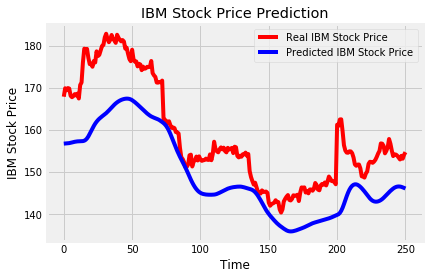

In [15]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [16]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 10.1010417269145.
